## Download the Data

For this example we will use the *California Housing* dataset. The target variable is the median house value in a block group, while the exploratory variables contains properties from houses in block groups, such as, the hosue age, the average number of bedrooms, the average number of rooms, and so on.  

In [22]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

First, we load the data as a dataframe

In [23]:
housing = fetch_california_housing(as_frame=True)

In [24]:
housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The `data` property contains only the exploratory variables (without the target variable)

In [25]:
housing.data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [26]:
housing.target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

## Get theTraining, Validation, and Test sets

Here we will scale our data with the `StandardScaler`, so all the features have mean 0 and variance 1. 

**Note: Do not fit the test nor the validation sets when using the `StandardCaler`**.

In [27]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [29]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(11610, 8)
(3870, 8)
(5160, 8)


## Create a Builder Function for the Model

In order to use cross validation methods from `scikit-learn` we need to use a wrapper and pass the model we will use for training. Here we will define a function that creates and compiles a neural network, with the following parameters:

* **n_hidden.** The number of hidden layers
* **n_neurons.** The number of neurons on each hidden layer
* **learning_rate.** The learning rate for the gradient descent algorithm.
* **input_shape.** The shape of the input layer


In [30]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    
    return model

Now we create a Keras Regressor wrapper and pass the builder function as a parameter

In [31]:
from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model)

## Training and Evaluating

Now we can train our neural network with the default parameters using the `fit` method. We need to specify the number of epochs, and we can use a large number since we are adding an *Early Stopping* condition. 

In [32]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

In [33]:
history = keras_reg.fit(X_train, 
                        y_train, 
                        epochs=100, 
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 0s 532us/step - loss: 1.1586 - val_loss: 0.6815
Epoch 2/100
363/363 [==============================] - 0s 401us/step - loss: 0.6188 - val_loss: 0.5841
Epoch 3/100
363/363 [==============================] - 0s 394us/step - loss: 0.5402 - val_loss: 0.5334
Epoch 4/100
363/363 [==============================] - 0s 400us/step - loss: 0.5002 - val_loss: 0.5073
Epoch 5/100
363/363 [==============================] - 0s 408us/step - loss: 0.4807 - val_loss: 0.4903
Epoch 6/100
363/363 [==============================] - 0s 406us/step - loss: 0.4667 - val_loss: 0.4825
Epoch 7/100
363/363 [==============================] - 0s 393us/step - loss: 0.4508 - val_loss: 0.4651
Epoch 8/100
363/363 [==============================] - 0s 394us/step - loss: 0.4426 - val_loss: 0.4600
Epoch 9/100
363/363 [==============================] - 0s 395us/step - loss: 0.4369 - val_loss: 0.4544
Epoch 10/100
363/363 [==============================] - 0s 406us/step - l

Epoch 80/100
363/363 [==============================] - 0s 390us/step - loss: 0.3414 - val_loss: 0.3810
Epoch 81/100
363/363 [==============================] - 0s 388us/step - loss: 0.3404 - val_loss: 0.3854
Epoch 82/100
363/363 [==============================] - 0s 390us/step - loss: 0.3445 - val_loss: 0.3904
Epoch 83/100
363/363 [==============================] - 0s 390us/step - loss: 0.3403 - val_loss: 0.3836
Epoch 84/100
363/363 [==============================] - 0s 391us/step - loss: 0.3419 - val_loss: 0.3814
Epoch 85/100
363/363 [==============================] - 0s 389us/step - loss: 0.3382 - val_loss: 0.3971
Epoch 86/100
363/363 [==============================] - 0s 385us/step - loss: 0.3406 - val_loss: 0.3886
Epoch 87/100
363/363 [==============================] - 0s 389us/step - loss: 0.3372 - val_loss: 0.3805
Epoch 88/100
363/363 [==============================] - 0s 387us/step - loss: 0.3383 - val_loss: 0.3835
Epoch 89/100
363/363 [==============================] - 0s 388us

As we did before, we can get the score from the test set, as well as predictions for new observations. 

In [34]:
mse_test = keras_reg.score(X_test, y_test)
mse_test

162/162 [==============================] - 0s 286us/step


0.7392659805784185

In [35]:
X_new = X_test[:3]
y_new = y_test[:3]
y_pred = keras_reg.predict(X_new)

print(y_new)
print(y_pred)

1/1 [==============================] - 0s 10ms/step
20046    0.47700
3024     0.45800
15663    5.00001
Name: MedHouseVal, dtype: float64
[0.39385572 1.3463789  3.783409  ]


/var/folders/fz/yn9wyn852cvd2npsc01_7fn40000gn/T/ipykernel_18285/2593341646.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_new = y_test[:3]


With the `history_` property, we obtain the record of the loss value for the training and validation sets.

<function matplotlib.pyplot.show(close=None, block=None)>

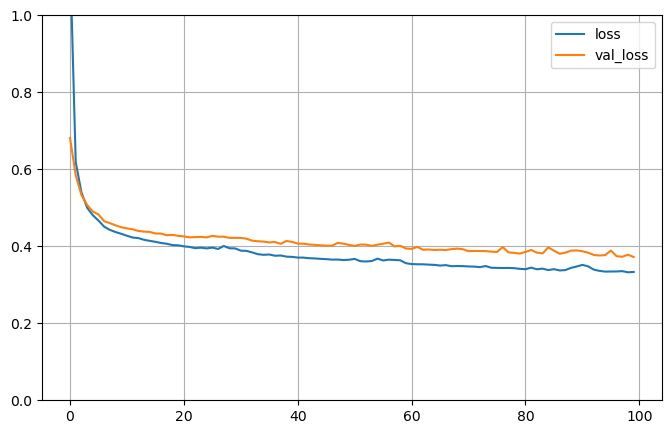

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history_).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show

## Fine-Tuning Hyperparameters

We don't know if the default parameters are actually the best, and since we are using a Keras Regressor, we can use some of the *Cross Validation* methods available in Keras.

First, we need to define a set of values for each parameter.

In [40]:
import numpy as np
from scipy.stats import loguniform, reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "model__n_hidden": [0, 1, 2, 3],
    "model__n_neurons": np.arange(1, 100).tolist(),
    "model__learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

Then, we train the model using a randomized cross validation, sampling ten different configurations with `k=3`.

In [41]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train,
                  y_train,
                  epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[early_stopping_cb])

Epoch 1/100
242/242 [==============================] - 0s 668us/step - loss: 0.9124 - val_loss: 0.6507
Epoch 2/100
242/242 [==============================] - 0s 496us/step - loss: 0.5579 - val_loss: 0.5208
Epoch 3/100
242/242 [==============================] - 0s 488us/step - loss: 0.4814 - val_loss: 0.4699
Epoch 4/100
242/242 [==============================] - 0s 486us/step - loss: 0.4483 - val_loss: 0.4473
Epoch 5/100
242/242 [==============================] - 0s 482us/step - loss: 0.4306 - val_loss: 0.4416
Epoch 6/100
242/242 [==============================] - 0s 531us/step - loss: 0.4172 - val_loss: 0.4229
Epoch 7/100
242/242 [==============================] - 0s 485us/step - loss: 0.4098 - val_loss: 0.4243
Epoch 8/100
242/242 [==============================] - 0s 476us/step - loss: 0.4014 - val_loss: 0.4449
Epoch 9/100
242/242 [==============================] - 0s 482us/step - loss: 0.3985 - val_loss: 0.4134
Epoch 10/100
242/242 [==============================] - 0s 477us/step - l

Epoch 80/100
242/242 [==============================] - 0s 472us/step - loss: 0.2883 - val_loss: 0.3269
Epoch 81/100
242/242 [==============================] - 0s 470us/step - loss: 0.2875 - val_loss: 0.3292
Epoch 82/100
242/242 [==============================] - 0s 472us/step - loss: 0.2849 - val_loss: 0.3275
Epoch 83/100
242/242 [==============================] - 0s 473us/step - loss: 0.2841 - val_loss: 0.3272
Epoch 84/100
242/242 [==============================] - 0s 472us/step - loss: 0.2832 - val_loss: 0.3594
Epoch 85/100
242/242 [==============================] - 0s 472us/step - loss: 0.2838 - val_loss: 0.3206
Epoch 86/100
242/242 [==============================] - 0s 472us/step - loss: 0.2825 - val_loss: 0.3290
Epoch 87/100
242/242 [==============================] - 0s 477us/step - loss: 0.2815 - val_loss: 0.3297
Epoch 88/100
242/242 [==============================] - 0s 474us/step - loss: 0.2842 - val_loss: 0.3237
Epoch 89/100
242/242 [==============================] - 0s 469us

242/242 [==============================] - 0s 496us/step - loss: 0.3068 - val_loss: 0.3639
Epoch 59/100
242/242 [==============================] - 0s 486us/step - loss: 0.3060 - val_loss: 0.3680
Epoch 60/100
242/242 [==============================] - 0s 497us/step - loss: 0.3039 - val_loss: 0.3598
Epoch 61/100
242/242 [==============================] - 0s 495us/step - loss: 0.3025 - val_loss: 0.3604
Epoch 62/100
242/242 [==============================] - 0s 484us/step - loss: 0.3017 - val_loss: 0.3644
Epoch 63/100
242/242 [==============================] - 0s 782us/step - loss: 0.3022 - val_loss: 0.3613
Epoch 64/100
242/242 [==============================] - 0s 538us/step - loss: 0.2993 - val_loss: 0.3689
Epoch 65/100
242/242 [==============================] - 0s 561us/step - loss: 0.3019 - val_loss: 0.3628
Epoch 66/100
242/242 [==============================] - 0s 504us/step - loss: 0.2993 - val_loss: 0.3638
Epoch 67/100
242/242 [==============================] - 0s 499us/step - loss:

242/242 [==============================] - 0s 472us/step - loss: 0.3301 - val_loss: 0.3684
Epoch 37/100
242/242 [==============================] - 0s 469us/step - loss: 0.3266 - val_loss: 0.4243
Epoch 38/100
242/242 [==============================] - 0s 470us/step - loss: 0.3260 - val_loss: 0.3628
Epoch 39/100
242/242 [==============================] - 0s 471us/step - loss: 0.3239 - val_loss: 0.3755
Epoch 40/100
242/242 [==============================] - 0s 477us/step - loss: 0.3243 - val_loss: 0.3636
Epoch 41/100
242/242 [==============================] - 0s 471us/step - loss: 0.3199 - val_loss: 0.3633
Epoch 42/100
242/242 [==============================] - 0s 470us/step - loss: 0.3226 - val_loss: 0.3870
Epoch 43/100
242/242 [==============================] - 0s 471us/step - loss: 0.3212 - val_loss: 0.3786
Epoch 44/100
242/242 [==============================] - 0s 473us/step - loss: 0.3183 - val_loss: 0.3634
Epoch 45/100
242/242 [==============================] - 0s 471us/step - loss:

242/242 [==============================] - 0s 486us/step - loss: 1.3845 - val_loss: 1.4035
Epoch 15/100
242/242 [==============================] - 0s 474us/step - loss: 1.3683 - val_loss: 1.3899
Epoch 16/100
242/242 [==============================] - 0s 480us/step - loss: 1.3564 - val_loss: 1.3800
Epoch 17/100
242/242 [==============================] - 0s 482us/step - loss: 1.3478 - val_loss: 1.3728
Epoch 18/100
242/242 [==============================] - 0s 480us/step - loss: 1.3416 - val_loss: 1.3676
Epoch 19/100
242/242 [==============================] - 0s 481us/step - loss: 1.3370 - val_loss: 1.3638
Epoch 20/100
242/242 [==============================] - 0s 479us/step - loss: 1.3337 - val_loss: 1.3610
Epoch 21/100
242/242 [==============================] - 0s 479us/step - loss: 1.3313 - val_loss: 1.3591
Epoch 22/100
242/242 [==============================] - 0s 479us/step - loss: 1.3295 - val_loss: 1.3576
Epoch 23/100
242/242 [==============================] - 0s 480us/step - loss:

Epoch 93/100
242/242 [==============================] - 0s 535us/step - loss: 1.3247 - val_loss: 1.3538
Epoch 94/100
242/242 [==============================] - 0s 481us/step - loss: 1.3247 - val_loss: 1.3538
Epoch 95/100
242/242 [==============================] - 0s 744us/step - loss: 1.3246 - val_loss: 1.3538
Epoch 96/100
242/242 [==============================] - 0s 494us/step - loss: 1.3246 - val_loss: 1.3538
Epoch 97/100
242/242 [==============================] - 0s 455us/step - loss: 1.3246 - val_loss: 1.3538
Epoch 98/100
242/242 [==============================] - 0s 493us/step - loss: 1.3246 - val_loss: 1.3538
Epoch 99/100
242/242 [==============================] - 0s 481us/step - loss: 1.3246 - val_loss: 1.3538
Epoch 100/100
121/121 [==============================] - 0s 284us/step
Epoch 1/100
242/242 [==============================] - 0s 679us/step - loss: 2.5144 - val_loss: 2.0628
Epoch 2/100
242/242 [==============================] - 0s 489us/step - loss: 1.6990 - val_loss: 1.

242/242 [==============================] - 0s 484us/step - loss: 0.4673 - val_loss: 0.4926
Epoch 72/100
242/242 [==============================] - 0s 482us/step - loss: 0.4668 - val_loss: 0.4922
Epoch 73/100
242/242 [==============================] - 0s 478us/step - loss: 0.4663 - val_loss: 0.4918
Epoch 74/100
242/242 [==============================] - 0s 481us/step - loss: 0.4659 - val_loss: 0.4914
Epoch 75/100
242/242 [==============================] - 0s 485us/step - loss: 0.4655 - val_loss: 0.4910
Epoch 76/100
242/242 [==============================] - 0s 505us/step - loss: 0.4650 - val_loss: 0.4907
Epoch 77/100
242/242 [==============================] - 0s 480us/step - loss: 0.4646 - val_loss: 0.4903
Epoch 78/100
242/242 [==============================] - 0s 481us/step - loss: 0.4642 - val_loss: 0.4900
Epoch 79/100
242/242 [==============================] - 0s 480us/step - loss: 0.4638 - val_loss: 0.4897
Epoch 80/100
242/242 [==============================] - 0s 480us/step - loss:

242/242 [==============================] - 0s 480us/step - loss: 0.6333 - val_loss: 0.6422
Epoch 50/100
242/242 [==============================] - 0s 484us/step - loss: 0.6303 - val_loss: 0.6401
Epoch 51/100
242/242 [==============================] - 0s 478us/step - loss: 0.6274 - val_loss: 0.6376
Epoch 52/100
242/242 [==============================] - 0s 474us/step - loss: 0.6245 - val_loss: 0.6354
Epoch 53/100
242/242 [==============================] - 0s 459us/step - loss: 0.6217 - val_loss: 0.6325
Epoch 54/100
242/242 [==============================] - 0s 478us/step - loss: 0.6192 - val_loss: 0.6305
Epoch 55/100
242/242 [==============================] - 0s 479us/step - loss: 0.6164 - val_loss: 0.6288
Epoch 56/100
242/242 [==============================] - 0s 480us/step - loss: 0.6136 - val_loss: 0.6258
Epoch 57/100
242/242 [==============================] - 0s 480us/step - loss: 0.6111 - val_loss: 0.6250
Epoch 58/100
242/242 [==============================] - 0s 480us/step - loss:

242/242 [==============================] - 0s 514us/step - loss: 0.4068 - val_loss: 0.4369
Epoch 28/100
242/242 [==============================] - 0s 458us/step - loss: 0.4053 - val_loss: 0.4360
Epoch 29/100
242/242 [==============================] - 0s 468us/step - loss: 0.4032 - val_loss: 0.4332
Epoch 30/100
242/242 [==============================] - 0s 448us/step - loss: 0.4020 - val_loss: 0.4333
Epoch 31/100
242/242 [==============================] - 0s 446us/step - loss: 0.4006 - val_loss: 0.4318
Epoch 32/100
242/242 [==============================] - 0s 447us/step - loss: 0.3990 - val_loss: 0.4297
Epoch 33/100
242/242 [==============================] - 0s 447us/step - loss: 0.3978 - val_loss: 0.4285
Epoch 34/100
242/242 [==============================] - 0s 446us/step - loss: 0.3960 - val_loss: 0.4281
Epoch 35/100
242/242 [==============================] - 0s 452us/step - loss: 0.3948 - val_loss: 0.4274
Epoch 36/100
242/242 [==============================] - 0s 465us/step - loss:

242/242 [==============================] - 0s 445us/step - loss: 0.5302 - val_loss: 0.5492
Epoch 6/100
242/242 [==============================] - 0s 448us/step - loss: 0.5059 - val_loss: 0.5300
Epoch 7/100
242/242 [==============================] - 0s 439us/step - loss: 0.4879 - val_loss: 0.5126
Epoch 8/100
242/242 [==============================] - 0s 440us/step - loss: 0.4728 - val_loss: 0.5020
Epoch 9/100
242/242 [==============================] - 0s 441us/step - loss: 0.4612 - val_loss: 0.4906
Epoch 10/100
242/242 [==============================] - 0s 438us/step - loss: 0.4527 - val_loss: 0.4850
Epoch 11/100
242/242 [==============================] - 0s 441us/step - loss: 0.4444 - val_loss: 0.4762
Epoch 12/100
242/242 [==============================] - 0s 442us/step - loss: 0.4383 - val_loss: 0.4705
Epoch 13/100
242/242 [==============================] - 0s 440us/step - loss: 0.4336 - val_loss: 0.4674
Epoch 14/100
242/242 [==============================] - 0s 440us/step - loss: 0.4

Epoch 84/100
242/242 [==============================] - 0s 442us/step - loss: 0.3485 - val_loss: 0.3944
Epoch 85/100
242/242 [==============================] - 0s 439us/step - loss: 0.3482 - val_loss: 0.3943
Epoch 86/100
242/242 [==============================] - 0s 441us/step - loss: 0.3468 - val_loss: 0.3971
Epoch 87/100
242/242 [==============================] - 0s 443us/step - loss: 0.3491 - val_loss: 0.3975
Epoch 88/100
242/242 [==============================] - 0s 442us/step - loss: 0.3470 - val_loss: 0.3953
Epoch 89/100
242/242 [==============================] - 0s 446us/step - loss: 0.3464 - val_loss: 0.3918
Epoch 90/100
242/242 [==============================] - 0s 440us/step - loss: 0.3456 - val_loss: 0.3971
Epoch 91/100
242/242 [==============================] - 0s 438us/step - loss: 0.3450 - val_loss: 0.3972
Epoch 92/100
242/242 [==============================] - 0s 438us/step - loss: 0.3456 - val_loss: 0.3994
Epoch 93/100
242/242 [==============================] - 0s 437us

242/242 [==============================] - 0s 456us/step - loss: 0.3782 - val_loss: 0.4078
Epoch 63/100
242/242 [==============================] - 0s 833us/step - loss: 0.3776 - val_loss: 0.4067
Epoch 64/100
242/242 [==============================] - 0s 544us/step - loss: 0.3770 - val_loss: 0.4057
Epoch 65/100
242/242 [==============================] - 0s 494us/step - loss: 0.3763 - val_loss: 0.4050
Epoch 66/100
242/242 [==============================] - 0s 539us/step - loss: 0.3756 - val_loss: 0.4049
Epoch 67/100
242/242 [==============================] - 0s 492us/step - loss: 0.3746 - val_loss: 0.4030
Epoch 68/100
242/242 [==============================] - 0s 533us/step - loss: 0.3743 - val_loss: 0.4053
Epoch 69/100
242/242 [==============================] - 0s 563us/step - loss: 0.3735 - val_loss: 0.4052
Epoch 70/100
242/242 [==============================] - 0s 457us/step - loss: 0.3728 - val_loss: 0.4033
Epoch 71/100
242/242 [==============================] - 0s 482us/step - loss:

242/242 [==============================] - 0s 498us/step - loss: 0.2954 - val_loss: 0.3453
Epoch 41/100
242/242 [==============================] - 0s 498us/step - loss: 0.2951 - val_loss: 0.3368
Epoch 42/100
242/242 [==============================] - 0s 485us/step - loss: 0.2940 - val_loss: 0.3378
Epoch 43/100
242/242 [==============================] - 0s 499us/step - loss: 0.2937 - val_loss: 0.3383
Epoch 44/100
242/242 [==============================] - 0s 505us/step - loss: 0.2918 - val_loss: 0.3522
Epoch 45/100
242/242 [==============================] - 0s 502us/step - loss: 0.2929 - val_loss: 0.3394
Epoch 46/100
242/242 [==============================] - 0s 501us/step - loss: 0.2934 - val_loss: 0.3369
Epoch 47/100
242/242 [==============================] - 0s 495us/step - loss: 0.2896 - val_loss: 0.3313
Epoch 48/100
242/242 [==============================] - 0s 501us/step - loss: 0.2893 - val_loss: 0.3299
Epoch 49/100
242/242 [==============================] - 0s 495us/step - loss:

242/242 [==============================] - 0s 522us/step - loss: 0.3343 - val_loss: 0.3752
Epoch 19/100
242/242 [==============================] - 0s 499us/step - loss: 0.3313 - val_loss: 0.3790
Epoch 20/100
242/242 [==============================] - 0s 505us/step - loss: 0.3308 - val_loss: 0.3804
Epoch 21/100
242/242 [==============================] - 0s 504us/step - loss: 0.3262 - val_loss: 0.3699
Epoch 22/100
242/242 [==============================] - 0s 497us/step - loss: 0.3257 - val_loss: 0.3862
Epoch 23/100
242/242 [==============================] - 0s 494us/step - loss: 0.3331 - val_loss: 0.3852
Epoch 24/100
242/242 [==============================] - 0s 487us/step - loss: 0.3351 - val_loss: 0.3744
Epoch 25/100
242/242 [==============================] - 0s 541us/step - loss: 0.3211 - val_loss: 0.3650
Epoch 26/100
242/242 [==============================] - 0s 499us/step - loss: 0.3130 - val_loss: 0.3695
Epoch 27/100
242/242 [==============================] - 0s 499us/step - loss:

Epoch 97/100
242/242 [==============================] - 0s 484us/step - loss: 0.2600 - val_loss: 0.3189
Epoch 98/100
242/242 [==============================] - 0s 491us/step - loss: 0.2596 - val_loss: 0.3319
Epoch 99/100
242/242 [==============================] - 0s 483us/step - loss: 0.2597 - val_loss: 0.3239
Epoch 100/100
121/121 [==============================] - 0s 288us/step
Epoch 1/100
242/242 [==============================] - 0s 686us/step - loss: 1.1521 - val_loss: 0.6345
Epoch 2/100
242/242 [==============================] - 0s 516us/step - loss: 0.5999 - val_loss: 0.6680
Epoch 3/100
242/242 [==============================] - 0s 498us/step - loss: 0.5334 - val_loss: 0.4793
Epoch 4/100
242/242 [==============================] - 0s 493us/step - loss: 0.4506 - val_loss: 0.4438
Epoch 5/100
242/242 [==============================] - 0s 486us/step - loss: 0.4145 - val_loss: 0.4287
Epoch 6/100
242/242 [==============================] - 0s 488us/step - loss: 0.4017 - val_loss: 0.4198

242/242 [==============================] - 0s 490us/step - loss: 0.2718 - val_loss: 0.3391
Epoch 76/100
242/242 [==============================] - 0s 487us/step - loss: 0.2717 - val_loss: 0.3292
Epoch 77/100
242/242 [==============================] - 0s 492us/step - loss: 0.2698 - val_loss: 0.3301
Epoch 78/100
242/242 [==============================] - 0s 493us/step - loss: 0.2720 - val_loss: 0.3311
Epoch 79/100
242/242 [==============================] - 0s 488us/step - loss: 0.2707 - val_loss: 0.3210
Epoch 80/100
242/242 [==============================] - 0s 498us/step - loss: 0.2667 - val_loss: 0.3424
Epoch 81/100
242/242 [==============================] - 0s 484us/step - loss: 0.2680 - val_loss: 0.3245
Epoch 82/100
242/242 [==============================] - 0s 487us/step - loss: 0.2657 - val_loss: 0.3447
Epoch 83/100
242/242 [==============================] - 0s 482us/step - loss: 0.2644 - val_loss: 0.3284
Epoch 84/100
242/242 [==============================] - 0s 488us/step - loss:

242/242 [==============================] - 0s 445us/step - loss: 0.4676 - val_loss: 0.4999
Epoch 54/100
242/242 [==============================] - 0s 447us/step - loss: 0.4665 - val_loss: 0.4993
Epoch 55/100
242/242 [==============================] - 0s 446us/step - loss: 0.4653 - val_loss: 0.4983
Epoch 56/100
242/242 [==============================] - 0s 448us/step - loss: 0.4644 - val_loss: 0.4978
Epoch 57/100
242/242 [==============================] - 0s 444us/step - loss: 0.4636 - val_loss: 0.4980
Epoch 58/100
242/242 [==============================] - 0s 444us/step - loss: 0.4627 - val_loss: 0.4970
Epoch 59/100
242/242 [==============================] - 0s 448us/step - loss: 0.4618 - val_loss: 0.4952
Epoch 60/100
242/242 [==============================] - 0s 446us/step - loss: 0.4608 - val_loss: 0.4937
Epoch 61/100
242/242 [==============================] - 0s 465us/step - loss: 0.4600 - val_loss: 0.4925
Epoch 62/100
242/242 [==============================] - 0s 451us/step - loss:

242/242 [==============================] - 0s 448us/step - loss: 0.4772 - val_loss: 0.5064
Epoch 32/100
242/242 [==============================] - 0s 446us/step - loss: 0.4752 - val_loss: 0.5045
Epoch 33/100
242/242 [==============================] - 0s 446us/step - loss: 0.4732 - val_loss: 0.5032
Epoch 34/100
242/242 [==============================] - 0s 448us/step - loss: 0.4722 - val_loss: 0.5016
Epoch 35/100
242/242 [==============================] - 0s 452us/step - loss: 0.4707 - val_loss: 0.5004
Epoch 36/100
242/242 [==============================] - 0s 447us/step - loss: 0.4695 - val_loss: 0.4989
Epoch 37/100
242/242 [==============================] - 0s 446us/step - loss: 0.4682 - val_loss: 0.4978
Epoch 38/100
242/242 [==============================] - 0s 446us/step - loss: 0.4674 - val_loss: 0.4964
Epoch 39/100
242/242 [==============================] - 0s 452us/step - loss: 0.4661 - val_loss: 0.4954
Epoch 40/100
242/242 [==============================] - 0s 464us/step - loss:

242/242 [==============================] - 0s 444us/step - loss: 0.6092 - val_loss: 0.5989
Epoch 10/100
242/242 [==============================] - 0s 454us/step - loss: 0.5962 - val_loss: 0.5877
Epoch 11/100
242/242 [==============================] - 0s 450us/step - loss: 0.5844 - val_loss: 0.5769
Epoch 12/100
242/242 [==============================] - 0s 458us/step - loss: 0.5733 - val_loss: 0.5668
Epoch 13/100
242/242 [==============================] - 0s 444us/step - loss: 0.5632 - val_loss: 0.5585
Epoch 14/100
242/242 [==============================] - 0s 448us/step - loss: 0.5540 - val_loss: 0.5507
Epoch 15/100
242/242 [==============================] - 0s 446us/step - loss: 0.5453 - val_loss: 0.5431
Epoch 16/100
242/242 [==============================] - 0s 442us/step - loss: 0.5379 - val_loss: 0.5379
Epoch 17/100
242/242 [==============================] - 0s 442us/step - loss: 0.5312 - val_loss: 0.5309
Epoch 18/100
242/242 [==============================] - 0s 446us/step - loss:

Epoch 88/100
242/242 [==============================] - 0s 455us/step - loss: 0.4387 - val_loss: 0.4516
Epoch 89/100
242/242 [==============================] - 0s 449us/step - loss: 0.4381 - val_loss: 0.4514
Epoch 90/100
242/242 [==============================] - 0s 456us/step - loss: 0.4377 - val_loss: 0.4502
Epoch 91/100
242/242 [==============================] - 0s 477us/step - loss: 0.4370 - val_loss: 0.4496
Epoch 92/100
242/242 [==============================] - 0s 495us/step - loss: 0.4364 - val_loss: 0.4496
Epoch 93/100
242/242 [==============================] - 0s 458us/step - loss: 0.4358 - val_loss: 0.4488
Epoch 94/100
242/242 [==============================] - 0s 458us/step - loss: 0.4354 - val_loss: 0.4484
Epoch 95/100
242/242 [==============================] - 0s 447us/step - loss: 0.4348 - val_loss: 0.4481
Epoch 96/100
242/242 [==============================] - 0s 449us/step - loss: 0.4341 - val_loss: 0.4484
Epoch 97/100
242/242 [==============================] - 0s 656us

242/242 [==============================] - 0s 485us/step - loss: 0.2734 - val_loss: 0.3337
Epoch 67/100
242/242 [==============================] - 0s 479us/step - loss: 0.2735 - val_loss: 0.3397
Epoch 68/100
242/242 [==============================] - 0s 481us/step - loss: 0.2762 - val_loss: 0.3373
Epoch 69/100
242/242 [==============================] - 0s 478us/step - loss: 0.2725 - val_loss: 0.3322
Epoch 70/100
242/242 [==============================] - 0s 479us/step - loss: 0.2750 - val_loss: 0.3297
Epoch 71/100
242/242 [==============================] - 0s 481us/step - loss: 0.2713 - val_loss: 0.3356
Epoch 72/100
242/242 [==============================] - 0s 482us/step - loss: 0.2731 - val_loss: 0.3297
Epoch 73/100
242/242 [==============================] - 0s 480us/step - loss: 0.2685 - val_loss: 0.3481
Epoch 74/100
242/242 [==============================] - 0s 477us/step - loss: 0.2696 - val_loss: 0.3494
Epoch 75/100
242/242 [==============================] - 0s 474us/step - loss:

242/242 [==============================] - 0s 492us/step - loss: 0.2950 - val_loss: 0.3443
Epoch 45/100
242/242 [==============================] - 0s 482us/step - loss: 0.2924 - val_loss: 0.3387
Epoch 46/100
242/242 [==============================] - 0s 479us/step - loss: 0.2927 - val_loss: 0.3407
Epoch 47/100
242/242 [==============================] - 0s 484us/step - loss: 0.2910 - val_loss: 0.3386
Epoch 48/100
242/242 [==============================] - 0s 483us/step - loss: 0.2889 - val_loss: 0.3488
Epoch 49/100
242/242 [==============================] - 0s 483us/step - loss: 0.2877 - val_loss: 0.3329
Epoch 50/100
242/242 [==============================] - 0s 489us/step - loss: 0.2873 - val_loss: 0.3425
Epoch 51/100
242/242 [==============================] - 0s 489us/step - loss: 0.2864 - val_loss: 0.3379
Epoch 52/100
242/242 [==============================] - 0s 483us/step - loss: 0.2851 - val_loss: 0.3384
Epoch 53/100
242/242 [==============================] - 0s 488us/step - loss:

242/242 [==============================] - 0s 487us/step - loss: 0.3316 - val_loss: 0.3666
Epoch 23/100
242/242 [==============================] - 0s 481us/step - loss: 0.3282 - val_loss: 0.4082
Epoch 24/100
242/242 [==============================] - 0s 481us/step - loss: 0.3304 - val_loss: 0.3710
Epoch 25/100
242/242 [==============================] - 0s 483us/step - loss: 0.3214 - val_loss: 0.3681
Epoch 26/100
242/242 [==============================] - 0s 493us/step - loss: 0.3217 - val_loss: 0.3597
Epoch 27/100
242/242 [==============================] - 0s 483us/step - loss: 0.3202 - val_loss: 0.3696
Epoch 28/100
242/242 [==============================] - 0s 485us/step - loss: 0.3184 - val_loss: 0.3567
Epoch 29/100
242/242 [==============================] - 0s 486us/step - loss: 0.3146 - val_loss: 0.3674
Epoch 30/100
242/242 [==============================] - 0s 486us/step - loss: 0.3135 - val_loss: 0.3540
Epoch 31/100
242/242 [==============================] - 0s 478us/step - loss:

121/121 [==============================] - 0s 281us/step
Epoch 1/100
242/242 [==============================] - 0s 712us/step - loss: 0.9385 - val_loss: 0.6047
Epoch 2/100
242/242 [==============================] - 0s 509us/step - loss: 0.5311 - val_loss: 0.4958
Epoch 3/100
242/242 [==============================] - 0s 510us/step - loss: 0.4570 - val_loss: 0.4598
Epoch 4/100
242/242 [==============================] - 0s 505us/step - loss: 0.4273 - val_loss: 0.4485
Epoch 5/100
242/242 [==============================] - 0s 506us/step - loss: 0.4131 - val_loss: 0.4400
Epoch 6/100
242/242 [==============================] - 0s 510us/step - loss: 0.4001 - val_loss: 0.4258
Epoch 7/100
242/242 [==============================] - 0s 527us/step - loss: 0.3915 - val_loss: 0.4193
Epoch 8/100
242/242 [==============================] - 0s 508us/step - loss: 0.3819 - val_loss: 0.4607
Epoch 9/100
242/242 [==============================] - 0s 507us/step - loss: 0.3781 - val_loss: 0.4101
Epoch 10/100
242

242/242 [==============================] - 0s 731us/step - loss: 0.2607 - val_loss: 0.3442
Epoch 80/100
242/242 [==============================] - 0s 527us/step - loss: 0.2612 - val_loss: 0.3194
Epoch 81/100
242/242 [==============================] - 0s 517us/step - loss: 0.2607 - val_loss: 0.3186
Epoch 82/100
242/242 [==============================] - 0s 513us/step - loss: 0.2589 - val_loss: 0.3110
Epoch 83/100
242/242 [==============================] - 0s 509us/step - loss: 0.2597 - val_loss: 0.3184
Epoch 84/100
242/242 [==============================] - 0s 506us/step - loss: 0.2570 - val_loss: 0.3411
Epoch 85/100
242/242 [==============================] - 0s 509us/step - loss: 0.2569 - val_loss: 0.3109
Epoch 86/100
242/242 [==============================] - 0s 509us/step - loss: 0.2563 - val_loss: 0.3154
Epoch 87/100
242/242 [==============================] - 0s 506us/step - loss: 0.2555 - val_loss: 0.3315
Epoch 88/100
242/242 [==============================] - 0s 520us/step - loss:

242/242 [==============================] - 0s 518us/step - loss: 0.2699 - val_loss: 0.3328
Epoch 58/100
242/242 [==============================] - 0s 510us/step - loss: 0.2714 - val_loss: 0.3296
Epoch 59/100
242/242 [==============================] - 0s 527us/step - loss: 0.2703 - val_loss: 0.3409
Epoch 60/100
242/242 [==============================] - 0s 580us/step - loss: 0.2677 - val_loss: 0.3246
Epoch 61/100
242/242 [==============================] - 0s 570us/step - loss: 0.2674 - val_loss: 0.3310
Epoch 62/100
242/242 [==============================] - 0s 535us/step - loss: 0.2669 - val_loss: 0.3334
Epoch 63/100
242/242 [==============================] - 0s 599us/step - loss: 0.2684 - val_loss: 0.3238
Epoch 64/100
242/242 [==============================] - 0s 525us/step - loss: 0.2634 - val_loss: 0.3375
Epoch 65/100
242/242 [==============================] - 0s 514us/step - loss: 0.2675 - val_loss: 0.3296
Epoch 66/100
242/242 [==============================] - 0s 522us/step - loss:

242/242 [==============================] - 0s 509us/step - loss: 0.2984 - val_loss: 0.3579
Epoch 36/100
242/242 [==============================] - 0s 851us/step - loss: 0.3007 - val_loss: 0.3325
Epoch 37/100
242/242 [==============================] - 0s 536us/step - loss: 0.2945 - val_loss: 0.3849
Epoch 38/100
242/242 [==============================] - 0s 528us/step - loss: 0.2963 - val_loss: 0.3300
Epoch 39/100
242/242 [==============================] - 0s 535us/step - loss: 0.2945 - val_loss: 0.3455
Epoch 40/100
242/242 [==============================] - 0s 544us/step - loss: 0.2955 - val_loss: 0.3324
Epoch 41/100
242/242 [==============================] - 0s 530us/step - loss: 0.2909 - val_loss: 0.3293
Epoch 42/100
242/242 [==============================] - 0s 512us/step - loss: 0.2937 - val_loss: 0.3720
Epoch 43/100
242/242 [==============================] - 0s 557us/step - loss: 0.2930 - val_loss: 0.3448
Epoch 44/100
242/242 [==============================] - 0s 539us/step - loss:

242/242 [==============================] - 0s 487us/step - loss: 0.4309 - val_loss: 0.4550
Epoch 14/100
242/242 [==============================] - 0s 477us/step - loss: 0.4262 - val_loss: 0.4453
Epoch 15/100
242/242 [==============================] - 0s 720us/step - loss: 0.4223 - val_loss: 0.4474
Epoch 16/100
242/242 [==============================] - 0s 484us/step - loss: 0.4198 - val_loss: 0.4409
Epoch 17/100
242/242 [==============================] - 0s 496us/step - loss: 0.4160 - val_loss: 0.4380
Epoch 18/100
242/242 [==============================] - 0s 495us/step - loss: 0.4124 - val_loss: 0.4367
Epoch 19/100
242/242 [==============================] - 0s 493us/step - loss: 0.4090 - val_loss: 0.4402
Epoch 20/100
242/242 [==============================] - 0s 483us/step - loss: 0.4067 - val_loss: 0.4304
Epoch 21/100
242/242 [==============================] - 0s 494us/step - loss: 0.4041 - val_loss: 0.4314
Epoch 22/100
242/242 [==============================] - 0s 500us/step - loss:

Epoch 92/100
242/242 [==============================] - 0s 500us/step - loss: 0.3227 - val_loss: 0.3640
Epoch 93/100
242/242 [==============================] - 0s 481us/step - loss: 0.3225 - val_loss: 0.3718
Epoch 94/100
242/242 [==============================] - 0s 497us/step - loss: 0.3222 - val_loss: 0.3598
Epoch 95/100
242/242 [==============================] - 0s 485us/step - loss: 0.3210 - val_loss: 0.3642
Epoch 96/100
242/242 [==============================] - 0s 474us/step - loss: 0.3204 - val_loss: 0.3587
Epoch 97/100
242/242 [==============================] - 0s 473us/step - loss: 0.3189 - val_loss: 0.3609
Epoch 98/100
242/242 [==============================] - 0s 476us/step - loss: 0.3201 - val_loss: 0.3582
Epoch 99/100
242/242 [==============================] - 0s 472us/step - loss: 0.3183 - val_loss: 0.3594
Epoch 100/100
121/121 [==============================] - 0s 275us/step
Epoch 1/100
242/242 [==============================] - 0s 737us/step - loss: 1.4282 - val_loss: 0

242/242 [==============================] - 0s 477us/step - loss: 0.3317 - val_loss: 0.3868
Epoch 71/100
242/242 [==============================] - 0s 871us/step - loss: 0.3292 - val_loss: 0.3864
Epoch 72/100
242/242 [==============================] - 0s 484us/step - loss: 0.3284 - val_loss: 0.3875
Epoch 73/100
242/242 [==============================] - 0s 479us/step - loss: 0.3280 - val_loss: 0.3865
Epoch 74/100
242/242 [==============================] - 0s 473us/step - loss: 0.3270 - val_loss: 0.3841
Epoch 75/100
242/242 [==============================] - 0s 475us/step - loss: 0.3272 - val_loss: 0.3864
Epoch 76/100
242/242 [==============================] - 0s 474us/step - loss: 0.3266 - val_loss: 0.3858
Epoch 77/100
242/242 [==============================] - 0s 475us/step - loss: 0.3250 - val_loss: 0.3854
Epoch 78/100
242/242 [==============================] - 0s 489us/step - loss: 0.3244 - val_loss: 0.3843
Epoch 79/100
242/242 [==============================] - 0s 504us/step - loss:

242/242 [==============================] - 0s 473us/step - loss: 0.3567 - val_loss: 0.3987
Epoch 49/100
242/242 [==============================] - 0s 476us/step - loss: 0.3556 - val_loss: 0.3976
Epoch 50/100
242/242 [==============================] - 0s 488us/step - loss: 0.3548 - val_loss: 0.3962
Epoch 51/100
242/242 [==============================] - 0s 502us/step - loss: 0.3529 - val_loss: 0.3950
Epoch 52/100
242/242 [==============================] - 0s 489us/step - loss: 0.3525 - val_loss: 0.3944
Epoch 53/100
242/242 [==============================] - 0s 485us/step - loss: 0.3512 - val_loss: 0.3929
Epoch 54/100
242/242 [==============================] - 0s 499us/step - loss: 0.3502 - val_loss: 0.3920
Epoch 55/100
242/242 [==============================] - 0s 499us/step - loss: 0.3491 - val_loss: 0.3940
Epoch 56/100
242/242 [==============================] - 0s 491us/step - loss: 0.3484 - val_loss: 0.3932
Epoch 57/100
242/242 [==============================] - 0s 494us/step - loss:

242/242 [==============================] - 0s 458us/step - loss: 0.5296 - val_loss: 0.5431
Epoch 27/100
242/242 [==============================] - 0s 450us/step - loss: 0.5318 - val_loss: 0.5391
Epoch 28/100
242/242 [==============================] - 0s 456us/step - loss: 0.5269 - val_loss: 0.5529
Epoch 29/100
242/242 [==============================] - 0s 430us/step - loss: 0.5374 - val_loss: 0.5468
Epoch 30/100
242/242 [==============================] - 0s 442us/step - loss: 0.5408 - val_loss: 0.5418
Epoch 31/100
242/242 [==============================] - 0s 434us/step - loss: 0.5261 - val_loss: 0.5525
Epoch 32/100
242/242 [==============================] - 0s 421us/step - loss: 0.5354 - val_loss: 0.5390
Epoch 33/100
242/242 [==============================] - 0s 420us/step - loss: 0.5292 - val_loss: 0.5458
Epoch 34/100
242/242 [==============================] - 0s 420us/step - loss: 0.5272 - val_loss: 0.5638
Epoch 35/100
242/242 [==============================] - 0s 419us/step - loss:

242/242 [==============================] - 0s 425us/step - loss: 4266.4810 - val_loss: 15374.7832
Epoch 5/100
242/242 [==============================] - 0s 423us/step - loss: 234486.8281 - val_loss: 513228.2812
Epoch 6/100
242/242 [==============================] - 0s 420us/step - loss: 523519.8125 - val_loss: 16968456.0000
Epoch 7/100
242/242 [==============================] - 0s 419us/step - loss: 15591908.0000 - val_loss: 559842432.0000
Epoch 8/100
242/242 [==============================] - 0s 424us/step - loss: 14062781440.0000 - val_loss: 17497174016.0000
Epoch 9/100
242/242 [==============================] - 0s 422us/step - loss: 178891505664.0000 - val_loss: 592606658560.0000
Epoch 10/100
242/242 [==============================] - 0s 424us/step - loss: 6123171086336.0000 - val_loss: 20131222650880.0000
Epoch 11/100
242/242 [==============================] - 0s 426us/step - loss: 968076367495168.0000 - val_loss: 641385719922688.0000
Epoch 12/100
242/242 [=========================

242/242 [==============================] - 0s 428us/step - loss: nan - val_loss: nan
Epoch 79/100
242/242 [==============================] - 0s 420us/step - loss: nan - val_loss: nan
Epoch 80/100
242/242 [==============================] - 0s 426us/step - loss: nan - val_loss: nan
Epoch 81/100
242/242 [==============================] - 0s 449us/step - loss: nan - val_loss: nan
Epoch 82/100
242/242 [==============================] - 0s 449us/step - loss: nan - val_loss: nan
Epoch 83/100
242/242 [==============================] - 0s 430us/step - loss: nan - val_loss: nan
Epoch 84/100
242/242 [==============================] - 0s 462us/step - loss: nan - val_loss: nan
Epoch 85/100
242/242 [==============================] - 0s 457us/step - loss: nan - val_loss: nan
Epoch 86/100
242/242 [==============================] - 0s 443us/step - loss: nan - val_loss: nan
Epoch 87/100
242/242 [==============================] - 0s 454us/step - loss: nan - val_loss: nan
Epoch 88/100
242/242 [===========

/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/scikeras/wrappers.py", line 1120, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/scikeras/wrappers.py", line 1717, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  F

242/242 [==============================] - 0s 607us/step - loss: 0.9302 - val_loss: 0.8205
Epoch 2/100
242/242 [==============================] - 0s 434us/step - loss: 1.2901 - val_loss: 40.5764
Epoch 3/100
242/242 [==============================] - 0s 426us/step - loss: 113.2854 - val_loss: 4117.2905
Epoch 4/100
242/242 [==============================] - 0s 429us/step - loss: 10056.2314 - val_loss: 437651.2188
Epoch 5/100
242/242 [==============================] - 0s 457us/step - loss: 1247738.1250 - val_loss: 46376540.0000
Epoch 6/100
242/242 [==============================] - 0s 431us/step - loss: 92798584.0000 - val_loss: 4978811392.0000
Epoch 7/100
242/242 [==============================] - 0s 432us/step - loss: 10817931264.0000 - val_loss: 524563447808.0000
Epoch 8/100
242/242 [==============================] - 0s 422us/step - loss: 1845197930496.0000 - val_loss: 55584825016320.0000
Epoch 9/100
242/242 [==============================] - 0s 437us/step - loss: 159213934346240.0000 

242/242 [==============================] - 0s 437us/step - loss: nan - val_loss: nan
Epoch 78/100
242/242 [==============================] - 0s 434us/step - loss: nan - val_loss: nan
Epoch 79/100
242/242 [==============================] - 0s 423us/step - loss: nan - val_loss: nan
Epoch 80/100
242/242 [==============================] - 0s 479us/step - loss: nan - val_loss: nan
Epoch 81/100
242/242 [==============================] - 0s 470us/step - loss: nan - val_loss: nan
Epoch 82/100
242/242 [==============================] - 0s 690us/step - loss: nan - val_loss: nan
Epoch 83/100
242/242 [==============================] - 0s 454us/step - loss: nan - val_loss: nan
Epoch 84/100
242/242 [==============================] - 0s 457us/step - loss: nan - val_loss: nan
Epoch 85/100
242/242 [==============================] - 0s 436us/step - loss: nan - val_loss: nan
Epoch 86/100
242/242 [==============================] - 0s 432us/step - loss: nan - val_loss: nan
Epoch 87/100
242/242 [===========

/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/scikeras/wrappers.py", line 1120, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/scikeras/wrappers.py", line 1717, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  F

242/242 [==============================] - 0s 661us/step - loss: 5.7404 - val_loss: 4.8116
Epoch 2/100
242/242 [==============================] - 0s 466us/step - loss: 4.0569 - val_loss: 3.5628
Epoch 3/100
242/242 [==============================] - 0s 444us/step - loss: 3.1083 - val_loss: 2.7830
Epoch 4/100
242/242 [==============================] - 0s 449us/step - loss: 2.4767 - val_loss: 2.2455
Epoch 5/100
242/242 [==============================] - 0s 446us/step - loss: 2.0341 - val_loss: 1.8699
Epoch 6/100
242/242 [==============================] - 0s 455us/step - loss: 1.7232 - val_loss: 1.6086
Epoch 7/100
242/242 [==============================] - 0s 463us/step - loss: 1.5058 - val_loss: 1.4274
Epoch 8/100
242/242 [==============================] - 0s 459us/step - loss: 1.3530 - val_loss: 1.2993
Epoch 9/100
242/242 [==============================] - 0s 455us/step - loss: 1.2436 - val_loss: 1.2062
Epoch 10/100
242/242 [==============================] - 0s 465us/step - loss: 1.1609 

Epoch 80/100
242/242 [==============================] - 0s 446us/step - loss: 0.4957 - val_loss: 0.5217
Epoch 81/100
242/242 [==============================] - 0s 440us/step - loss: 0.4945 - val_loss: 0.5205
Epoch 82/100
242/242 [==============================] - 0s 441us/step - loss: 0.4933 - val_loss: 0.5193
Epoch 83/100
242/242 [==============================] - 0s 441us/step - loss: 0.4922 - val_loss: 0.5182
Epoch 84/100
242/242 [==============================] - 0s 441us/step - loss: 0.4911 - val_loss: 0.5170
Epoch 85/100
242/242 [==============================] - 0s 442us/step - loss: 0.4900 - val_loss: 0.5159
Epoch 86/100
242/242 [==============================] - 0s 442us/step - loss: 0.4890 - val_loss: 0.5149
Epoch 87/100
242/242 [==============================] - 0s 447us/step - loss: 0.4879 - val_loss: 0.5138
Epoch 88/100
242/242 [==============================] - 0s 441us/step - loss: 0.4869 - val_loss: 0.5128
Epoch 89/100
242/242 [==============================] - 0s 441us

242/242 [==============================] - 0s 445us/step - loss: 0.4929 - val_loss: 0.5228
Epoch 59/100
242/242 [==============================] - 0s 440us/step - loss: 0.4916 - val_loss: 0.5215
Epoch 60/100
242/242 [==============================] - 0s 442us/step - loss: 0.4903 - val_loss: 0.5199
Epoch 61/100
242/242 [==============================] - 0s 438us/step - loss: 0.4890 - val_loss: 0.5185
Epoch 62/100
242/242 [==============================] - 0s 453us/step - loss: 0.4877 - val_loss: 0.5179
Epoch 63/100
242/242 [==============================] - 0s 461us/step - loss: 0.4865 - val_loss: 0.5160
Epoch 64/100
242/242 [==============================] - 0s 463us/step - loss: 0.4853 - val_loss: 0.5150
Epoch 65/100
242/242 [==============================] - 0s 462us/step - loss: 0.4841 - val_loss: 0.5139
Epoch 66/100
242/242 [==============================] - 0s 460us/step - loss: 0.4830 - val_loss: 0.5123
Epoch 67/100
242/242 [==============================] - 0s 440us/step - loss:

242/242 [==============================] - 0s 453us/step - loss: 0.5696 - val_loss: 0.5724
Epoch 37/100
242/242 [==============================] - 0s 443us/step - loss: 0.5659 - val_loss: 0.5697
Epoch 38/100
242/242 [==============================] - 0s 442us/step - loss: 0.5622 - val_loss: 0.5667
Epoch 39/100
242/242 [==============================] - 0s 444us/step - loss: 0.5588 - val_loss: 0.5632
Epoch 40/100
242/242 [==============================] - 0s 441us/step - loss: 0.5555 - val_loss: 0.5592
Epoch 41/100
242/242 [==============================] - 0s 459us/step - loss: 0.5522 - val_loss: 0.5565
Epoch 42/100
242/242 [==============================] - 0s 463us/step - loss: 0.5488 - val_loss: 0.5547
Epoch 43/100
242/242 [==============================] - 0s 462us/step - loss: 0.5462 - val_loss: 0.5508
Epoch 44/100
242/242 [==============================] - 0s 455us/step - loss: 0.5430 - val_loss: 0.5481
Epoch 45/100
242/242 [==============================] - 0s 463us/step - loss:

/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.76679902 0.41612827 0.72817234 0.76983736 0.66567194 0.76972786
 0.77844174 0.74730468        nan 0.64726137]
  warnings.warn(


363/363 [==============================] - 0s 582us/step - loss: 0.8353 - val_loss: 0.5122
Epoch 2/100
363/363 [==============================] - 0s 456us/step - loss: 0.4680 - val_loss: 0.4548
Epoch 3/100
363/363 [==============================] - 0s 459us/step - loss: 0.4224 - val_loss: 0.4264
Epoch 4/100
363/363 [==============================] - 0s 459us/step - loss: 0.4007 - val_loss: 0.4178
Epoch 5/100
363/363 [==============================] - 0s 457us/step - loss: 0.3874 - val_loss: 0.4031
Epoch 6/100
363/363 [==============================] - 0s 455us/step - loss: 0.3771 - val_loss: 0.3985
Epoch 7/100
363/363 [==============================] - 0s 456us/step - loss: 0.3691 - val_loss: 0.3899
Epoch 8/100
363/363 [==============================] - 0s 457us/step - loss: 0.3603 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 457us/step - loss: 0.3542 - val_loss: 0.3839
Epoch 10/100
363/363 [==============================] - 0s 457us/step - loss: 0.3505 

Epoch 80/100
363/363 [==============================] - 0s 457us/step - loss: 0.2539 - val_loss: 0.3061
Epoch 81/100
363/363 [==============================] - 0s 455us/step - loss: 0.2544 - val_loss: 0.3035
Epoch 82/100
363/363 [==============================] - 0s 456us/step - loss: 0.2552 - val_loss: 0.3148
Epoch 83/100
363/363 [==============================] - 0s 456us/step - loss: 0.2558 - val_loss: 0.3222
Epoch 84/100
363/363 [==============================] - 0s 455us/step - loss: 0.2539 - val_loss: 0.3025
Epoch 85/100
363/363 [==============================] - 0s 458us/step - loss: 0.2515 - val_loss: 0.3195
Epoch 86/100
363/363 [==============================] - 0s 456us/step - loss: 0.2514 - val_loss: 0.3091
Epoch 87/100
363/363 [==============================] - 0s 457us/step - loss: 0.2521 - val_loss: 0.3000
Epoch 88/100
363/363 [==============================] - 0s 456us/step - loss: 0.2515 - val_loss: 0.3084
Epoch 89/100
363/363 [==============================] - 0s 456us

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(model=<function build_model at 0x29e8a15e0>),
                   param_distributions={'model__learning_rate': [0.023070247095618657,
                                                                 0.0018812193571737948,
                                                                 0.0008643988194531686,
                                                                 0.0013501716206451731,
                                                                 0.015229009691375188,
                                                                 0.0029716549588189875,
                                                                 0.0015332955022550018,
                                                                 0.003678250463240318,
                                                                 0.0005540904555003274,
                                                                 0.00030749627843890...
                                                                 0.0023673335357571024,
                                                                 0.0007937507190397334,
                                                                 0.0011245302398817305,
                                                                 0.00592763702089295,
                                                                 0.0015637438415165158,
                                                                 0.003907188555283265,
                                                                 0.002004143286241076,
                                                                 0.0006532204398808047,
                                                                 0.00042185309062706496,
                                                                 0.0008903981425272313, ...],
                                        'model__n_hidden': [0, 1, 2, 3],
                                        'model__n_neurons': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...]})

The best set of parameters is given by the `best_params_` property.

In [42]:
rnd_search_cv.best_params_

{'model__n_neurons': 64,
 'model__n_hidden': 3,
 'model__learning_rate': 0.007484761545938902}

The `best_score_` property returns the mean of the score for each training using the best model.

In [43]:
rnd_search_cv.best_score_

0.7784417376041489

Now we can use the best score to evaluate the test set

In [44]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 290us/step


0.7789109358359112